In [24]:

import HERA_hack_FG
%load_ext autoreload
%autoreload 2

#these are for the telescope and observation
import numpy as np 
import numpy.linalg as la
import seaborn as sns
import pandas as pd
import os
from scipy import signal
import scipy.constants as sc



#these are only for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import time
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as patches


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup 

## HERA class 

#### Dishes
 - Input type: Nants x 2 array 
 - Input unit: meters
 - description: relative location of all dishes in array
#### latitude 
 - Input type: float 
 - Input unit: degree
 - description: latitude of array
 #### channel width
 - Input type: float
 - Input unit: Hz
 - description: width of channels
 #### Tsys
 - Input type: float
 - Input unit: K
 - description: brightness of system for computing rms noise
 #### Beam width
 - Input type: float 
 - Input unit: degrees
 - description: width of the primary beam
 
## Observation class 

#### Telescope                                                               
 - Input type: class 
 - Input unit: /
 - description: Telesope you're using 
####  n_days
 - Input type: float 
 - Input unit: days
 - description: number of observing days
 #### freq
 - Input type: float
 - Input unit: Hz
 - description: frequency of observation
 #### delta_t
 - Input type: float
 - Input unit: s
 - description: length of timestep
 #### acorner 
 - Input type: 4 x 2 array 
 - Input unit: degrees
 - description: observable corners of the sky 
 
 #### effective area
 - Input type: float 
 - Input unit: %
 - description: effective area of antenna
 
  #### beam sigma cutoff
 - Input type: float 
 - Input unit: standard deviations
 - description: number of standard deviation until 0 sensitivity
  #### resolution
 - Input type: float 
 - Input unit: degrees
 - description: resolution 
  #### pbeam
 - Input type: boolean
 - Input unit: /
 - description: True = include primary beam in Amat, False = do not 
  #### norm
 - Input type: boolean
 - Input unit: /
 - description: True = include norm in map, False = do not 

In [47]:
dishes = np.array([[0,0],[0,55],[30,30],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])

#observable corners of the sky [lat,long]
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])

#class setup
HERA = HERA_hack_FG.telescope(dishes, latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')

obs = HERA_hack_FG.observation(HERA, 100, 100, 0.01,acorner,1, 0.2, norm = False, pbeam = False)


#number of pixels in the map
npix =len(obs.observable_coordinates())

#useful VECTORS
v_rand = np.random.randn(npix) #random sky vector
mid_pixel = np.int(npix*0.5098507)
res = 0.3
res *= np.pi / 180
x = np.zeros(npix)
imp = signal.unit_impulse(npix, 200)
#imp = (signal.unit_impulse(npix, mid_pixel + np.int(((max(x)-min(x))/res)/2)))
#imp = signal.unit_impulse(npix, mid_pixel) #delta funtion point source in the middle
#imp_multi = signal.unit_impulse(npix, 'mid') + signal.unit_impulse(npix, 1234) +signal.unit_impulse(npix,193)+signal.unit_impulse(npix, 687)+signal.unit_impulse(npix, 1632)+ signal.unit_impulse(npix, 122 )+signal.unit_impulse(npix, 13)+signal.unit_impulse(npix, 1344)+signal.unit_impulse(npix, 45)



#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs.observable_coordinates())):
    x[i]= obs.observable_coordinates()[i,1] #phi
    y[i] = obs.observable_coordinates()[i,0]#theta

npix



1500

# Map 


When pbeam = True, you get this weird pixelated thing going on. What is strange is that once there are many baslines, these pixaleted things average down which you can see in the mutiple baseline notbeook which has pbeam = True. 



(1500, 3)
(1305, 1500)
(1500, 1500)
(1500, 3)


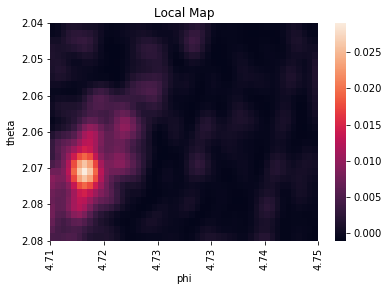

In [42]:

sky_map = np.real(obs.convolve_map(imp, None, None))

#sky_map_noise = np.real(obs.generate_map_noise())


df_obs = pd.DataFrame.from_dict(np.array([x,y,sky_map]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax)
0.3



ax.set_title('Local Map', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()


In [46]:
### computing individual pixel

Ax = obs.Amat[:,199]*imp[199]
At = (np.conj(obs.Amat)).T
invN = np.dot(obs.invN,Ax)

print(np.dot(At[199],invN))
print(sky_map[199])


0j
0.025885926431708024


In [48]:
np.real(obs.single_pix_convolve_map(199,imp,None,None))

(1500, 3)
(1305, 1500)
(1500, 1500)
(1500, 3)


0.025885926431708027

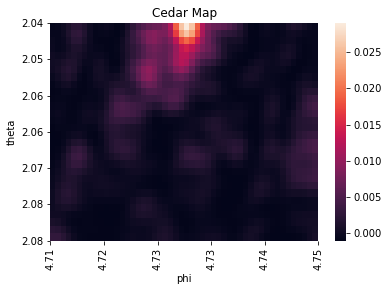

In [24]:
map_cedar = pd.read_csv('/Users/hannahfronenberg/Desktop/map.txt', header=None)
map_cedar.columns = ["Temp"]

a= np.asarray(map_cedar["Temp"])

cedar = pd.DataFrame.from_dict(np.array([x,y,a]).T)
cedar.columns = ['phi','theta','Temp']



pivotted_cedar= cedar.pivot('theta','phi','Temp')

ax = plt.axes()

sns.heatmap(pivotted_cedar,ax=ax)
# 0.3



ax.set_title('Cedar Map', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()



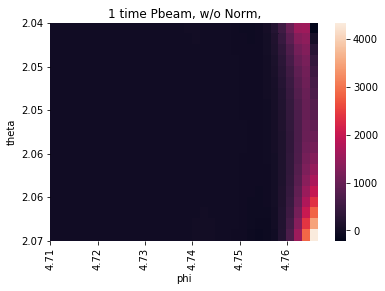

In [13]:
sky_map = np.real(obs.convolve_map(imp))

df_obs = pd.DataFrame.from_dict(np.array([x,y,sky_map]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax)
0.3



ax.set_title('1 time Pbeam, w/o Norm,', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

array([0.])

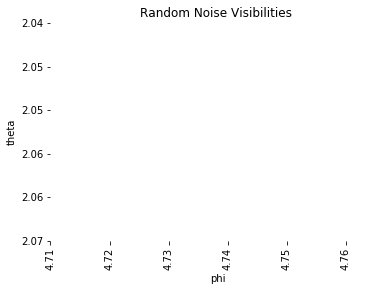

In [8]:
from celluloid import Camera




fig, ax= plt.subplots()

camera = Camera(fig)

for i in range(35):
    
    sky_map = np.real(obs.generate_map_noise())



    df_obs = pd.DataFrame.from_dict(np.asarray([x,y,sky_map]).T)
    df_obs.columns = ['phi','theta','temp']



    pivotted_obs= df_obs.pivot('theta','phi','temp')
    sns.heatmap(pivotted_obs,ax=ax, cbar = False)


    # Create a Rectangle patch #(bottom left corner pix), width in pix , height in pix
    rect1 = patches.Rectangle((0,0),1,1,linewidth=4,edgecolor='c',fill = False)
    rect2 = patches.Rectangle((i,0),1,1,linewidth=3,edgecolor='lime',fill = False)
    # Add the patch to the Axes
    ax.add_patch(rect1)
    ax.add_patch(rect2)


    ax.set_title('Random Noise Visibilities ', y = 1.04)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    ylabels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
    ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])
    
    camera.snap()
    
animation = camera.animate()

from IPython.display import HTML
HTML(animation.to_jshtml())
    #plt.show()

In [ ]:
2.092035-2.047272,pivotted_obs, print(sky_map[20]), 

# True Sky 

In [ ]:
#plotting the vector of the true sky signal
#df_sky = pd.DataFrame.from_dict(np.asarray([x,y,imp_multi]).T)
df_sky = pd.DataFrame.from_dict(np.asarray([x,y,imp]).T)
df_sky.columns = ['phi','theta','temp']
df_sky['Z_value'] = pd.to_numeric(df_obs['temp'])



pivotted_sky= df_sky.pivot('phi','theta','temp')
df_sky_transposed = pivotted_sky.transpose()

ax = plt.axes()
sns.heatmap(df_sky_transposed,ax=ax)
ax.set_title('Sky Signal')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])



plt.show()

# Visualisation of Primary Beam

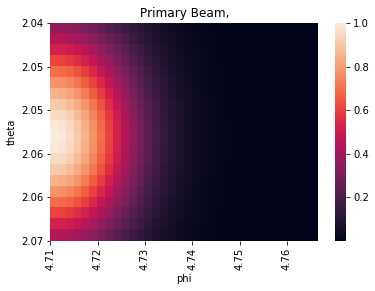

In [71]:
primary_beam = obs.pbeam[0,:] #primary beam at first time, 
                                    #as [i] increases, the beam drifst from left to right

df_obs = pd.DataFrame.from_dict(np.array([x,y,np.real(primary_beam)]).T)
df_obs.columns = ['phi','theta','temp']


pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax)


ax.set_title('Primary Beam,', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()





# Visualisation of Array

In [ ]:
#deparating x and y coordinates for each dish
x_arr = np.zeros(len(dishes))
y_arr = np.zeros(len(dishes))

for i in range(len(dishes)):
    x_arr[i]= dishes[i,0]
    y_arr[i] = dishes[i,1]


plt.scatter(x_arr,y_arr)
plt.title('My Telescope ')